# Evolutionary Algorithm

the Evolutionary Algorithm that is supposed to create new recipes based on the Recipe Matrices that are created during the *Recipe Analysis* step.

The Population of the Evolutional Algorithm consists of a set of recipe trees. Each Recipe Tree consists of several Nodes where each node is of one of the following Types:

* **Ingredient Node:**
  these are the leaf nodes. Containing an ingredient. The score is determined by the actions, that are applied if you follow up the path. At the Moment it measures how many duplicate actions are applied.
* **Action Node:**
  An Action that is applied on it's child and this child's subtree. Score indicates the average likelihood that this action is applied on the ingredients inside the subtree
* **Mix Node:**
  Mixing ingredients together. This is also the only Node that can have more than one child. The score is the average of all pairwise likelihoods that two ingredients are mixed togethter

In [1]:
cd ..

/home/jonas/Dokumente/gitRepos/AutoChef/src


In [3]:
import sys

In [2]:
import settings

import pandas as pd

import json

from RecipeAnalysis.Recipe import Ingredient

import ea_tools as ea_tools

from difflib import SequenceMatcher

import numpy as np

import RecipeAnalysis.ActionGroups as AG

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

from graphviz import Digraph

import itertools

import random

import plotly.io as pio
pio.renderers.default = "jupyterlab"

from IPython.display import Markdown, HTML, display

from tqdm.autonotebook import tqdm

from copy import deepcopy

In [4]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

## load adjacency matrices

In [5]:
import dill

module_root = "/".join(str(settings.__file__).split("/")[:-1]) + "/"
sys.path.append(module_root + "/RecipeAnalysis/")

m_act = dill.load(open(module_root + "/RecipeAnalysis/m_act.dill", "rb"))
m_mix = dill.load(open(module_root + "/RecipeAnalysis/m_mix.dill", "rb"))
m_base_act = dill.load(open(module_root + "/RecipeAnalysis/m_base_act.dill", "rb"))
m_base_mix = dill.load(open(module_root + "/RecipeAnalysis/m_base_mix.dill", "rb"))


m_grouped_mix = dill.load(open(module_root + "/RecipeAnalysis/m_grouped_mix_raw.dill", "rb"))
m_grouped_act = dill.load(open(module_root + "/RecipeAnalysis/m_grouped_act_raw.dill", "rb"))
m_grouped_base_act = dill.load(open(module_root + "/RecipeAnalysis/m_grouped_base_act_raw.dill", "rb"))


#m_act.apply_threshold(3)
#m_mix.apply_threshold(3)
#m_base_act.apply_threshold(5)
#m_base_mix.apply_threshold(5)


#c_act = m_act.get_csr()
#c_mix = m_mix.get_csr()
#c_base_act = m_base_act.get_csr()
#c_base_mix = m_base_mix.get_csr()

m_act.compile()
m_mix.compile()
m_base_act.compile()
m_base_mix.compile()

m_grouped_mix.compile()
m_grouped_act.compile()
m_grouped_base_act.compile()

c_act = m_act._csr
c_mix = m_mix._csr
c_base_act = m_base_act._csr
c_base_mix = m_base_mix._csr

In [6]:
c_grouped_mix = m_grouped_mix._csr
c_grouped_act = m_grouped_act._csr
c_grouped_base_act = m_grouped_base_act._csr

In [7]:
actions = m_act.get_labels()[0]

In [8]:
base_ingredients = m_base_mix.get_labels()
base_act_ingredients = m_base_act.get_labels()[1]

In [9]:
sym_label_buffer = {}
fw_label_buffer = {}
bw_label_buffer = {}

## load Carsten's food replacement library

In [12]:
sub_replacements_frame = pd.read_pickle(module_root + "/" + settings.data_root + "/foodsubs_dataframe.pb")

def get_path(food:str):
    try:
        return sub_replacements_frame[sub_replacements_frame.name==food].path.values[0]
    except:
        return None

def get_replacement_candidates(food:str):
    path = get_path(food)
    if path is None:
        return []
    
    tmp_list = [v[0] for v in sub_replacements_frame[sub_replacements_frame.path==path].values]
    
    final_list = []
    
    for item in tmp_list:
        if item in base_ingredients and item in base_act_ingredients and item != food:
            final_list.append(item)
    return final_list
        
    

### helper functions for adjacency matrices

In [13]:
def get_sym_adjacent(key, m, c):
    index = m._label_index[key]
    i1 = c[index,:].nonzero()[1]
    i2 = c[:,index].nonzero()[0]
    
    i = np.concatenate((i1,i2))
    
    if m in sym_label_buffer:
        names = sym_label_buffer[m][i]
    else:
        names = np.array(m.get_labels())
        sym_label_buffer[m] = names
        names = names[i]
    
    counts = np.concatenate((c[index, i1].toarray().flatten(), c[i2, index].toarray().flatten()))
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [14]:
def get_forward_adjacent(key, m, c):
    index = m._x_label_index[key]
    i = c[index,:].nonzero()[1]
    
    if m in fw_label_buffer:
        names = fw_label_buffer[m][i]
    else:
        names = np.array(m._y_labels)
        fw_label_buffer[m] = names
        names = names[i]
    
    
    counts = c[index, i].toarray().flatten()
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [15]:
def get_backward_adjacent(key, m, c):
    index = m._y_label_index[key]
    i = c[:,index].nonzero()[0]
    
    if m in bw_label_buffer:
        names = bw_label_buffer[m][i]
    else:
        names = np.array(m._x_labels)
        bw_label_buffer[m] = names
        names = names[i]
    
    
    counts = c[i, index].toarray().flatten()
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [16]:
def sym_sum(key, m, c):
    return np.sum(get_sym_adjacent(key,m,c)[1])

def fw_sum(key, m, c):
    return np.sum(get_forward_adjacent(key,m,c)[1])

def bw_sum(key, m, c):
    return np.sum(get_backward_adjacent(key,m,c)[1])

In [17]:
def to_grouped_ingredient(ing:Ingredient):
    groups = set()
    for act in ing._action_set:
        groups.add(AG.groups[act])
    grouped_ingredient = Ingredient(ing._base_ingredient)
    for g in groups:
        grouped_ingredient.apply_action(g)
    return grouped_ingredient

#### different score functions

##### normalizations

In [18]:
def fw_normalization_factor(key, m, c, quotient_func):
    ia = m._x_label_index[key]
    
    occurances = c[ia,:].nonzero()[1]
    
    return 1. / quotient_func(c[ia,occurances].toarray())

def bw_normalization_factor(key, m, c, quotient_func):
    ib = m._y_label_index[key]
    
    occurances = c[:,ib].nonzero()[0]
    
    return 1. / quotient_func(c[occurances,ib].toarray())

def sym_normalization_factor(key, m, c, quotient_func):
    ii = m._label_index[key]
    
    fw_occurances = c[ii,:].nonzero()[1]
    bw_occurances = c[:,ii].nonzero()[0]
    
    return 1. / quotient_func(np.concatenate(
        [c[ii,fw_occurances].toarray().flatten(),
         c[bw_occurances,ii].toarray().flatten()]
    ))

In [19]:
def sym_p_a_given_b(key_a, key_b, m, c, quot_func = np.max):
    ia = m._label_index[key_a]
    ib = m._label_index[key_b]
    
    v = c[ia,ib] + c[ib,ia]
    
    return v * sym_normalization_factor(key_b, m, c, quot_func)

def fw_p_a_given_b(key_a, key_b, m, c, quot_func = np.max):
    ia = m._x_label_index[key_a]
    ib = m._y_label_index[key_b]
    
    v = c[ia,ib]
    
    return v * bw_normalization_factor(key_b, m, c, quot_func)

def bw_p_a_given_b(key_a, key_b, m, c, quot_func = np.max):
    ia = m._y_label_index[key_a]
    ib = m._x_label_index[key_b]
    
    v = c[ib,ia]
    
    return v * fw_normalization_factor(key_b, m, c, quot_func)


In [20]:
def sym_score(key_a, key_b, m, c):

    ia = m._label_index[key_a]
    ib = m._label_index[key_b]
    
    v = c[ia,ib] + c[ib,ia]
    
    if v == 0:
        return 0
    
    return max((v/sym_sum(key_a, m, c)), (v/sym_sum(key_b, m, c)))

def asym_score(key_a, key_b, m, c):
    ia = m._x_label_index[key_a]
    ib = m._y_label_index[key_b]
    
    v = c[ia,ib]
    
    if v == 0:
        return 0
    
    return max(v/fw_sum(key_a, m, c), v/bw_sum(key_b, m, c))

In [21]:
def p_ingredient_unprepared(base_ing):
    ing = Ingredient(base_ing)
    base_sum = sym_sum(base_ing, m_base_mix, c_base_mix)
    specialized_sum = sym_sum(ing.to_json(), m_mix, c_mix)
    return specialized_sum / base_sum

**new probability for preprocess ingredients:**

In [22]:
PREPARE_RATIO_THRESHOLD = 0.35
HEAT_RATIO_THRESHOLD = 0.65

PREPARE_SCORE_EPS = 0.1
HEAT_SCORE_EPS = 0.1

def prepare_ratio(ing:str):
    try:
        keys, values = m_grouped_act.get_backward_adjacent(Ingredient(ing).to_json())
    except KeyError:
        return 0
    action_dict = dict(zip(keys,values))
    if 'prepare' not in action_dict:
        return 0
    if 'heat' not in action_dict:
        return 1
    return action_dict['prepare'] / action_dict['heat']

def random_prepare(ing:str):
    """
    returns randomly a boolean value if ing should be prepared, w.r.t. the prepare_ration function
    """
    
    return prepare_ratio(ing) > np.random.normal(PREPARE_RATIO_THRESHOLD,0.1)

def heat_ratio(ingredient:str):
    try:
        action_set, action_weights = m_grouped_base_act.get_backward_adjacent(ingredient)
    except KeyError:
        return 0
    d = dict(zip(action_set, action_weights))
    
    if 'prepare' not in d:
        return 1
    if 'heat' not in d:
        return 0
    
    ratio = 1 - d['prepare'] / d['heat']
    
    return ratio

def random_heated(ingredient:str):
    ratio = heat_ratio(ingredient)
    
    return ratio > np.random.normal(HEAT_RATIO_THRESHOLD,0.15)

def prepare_score(ingredient:Ingredient):
    ing_str = ingredient._base_ingredient
    
    g_ing = to_grouped_ingredient(ingredient)
    
    ratio = prepare_ratio(ing_str)
    
    if ratio > PREPARE_RATIO_THRESHOLD + PREPARE_SCORE_EPS:
        if 'prepare' not in g_ing._action_set:
            return 0
    
    if ratio < PREPARE_RATIO_THRESHOLD - PREPARE_SCORE_EPS:
        if 'prepare' in g_ing._action_set:
            return 0
    
    return 1

def heat_score(ingredient:Ingredient):
    ing_str = ingredient._base_ingredient
    
    g_ing = to_grouped_ingredient(ingredient)
    
    ratio = heat_ratio(ing_str)
    
    if ratio > HEAT_RATIO_THRESHOLD + HEAT_SCORE_EPS:
        if 'heat' not in g_ing._action_set:
            return 0
    
    if ratio < HEAT_RATIO_THRESHOLD - HEAT_SCORE_EPS:
        if 'heat' in g_ing._action_set:
            return 0
    
    return 1


In [23]:
def relative_action_rank(ingredient:str, action:str):
    action_set, action_weights = m_base_act.get_backward_adjacent(ingredient)
    if action not in action_set or len(action_set) <= 1:
        return 0
    return 1 - action_set.tolist().index(action) / (len(action_set) - 1)

In [24]:
def filter_set_by_group(act_set, act_w, group):
    new_act_set = []
    new_act_w = []
    for i in range(len(act_set)):
        if act_set[i] in AG.inverse_groups[group]:
            new_act_set.append(act_set[i])
            new_act_w.append(act_w[i])
    return np.array(new_act_set), np.array(new_act_w)

## better normalized scores:

In [25]:
def normalized_score(key, matrix):
    sum_key = matrix.get_sum(key)
    keys, values = matrix.get_adjacent(key)
    normalized_values = np.array([(values[i] / matrix.get_sum(keys[i])) * (values[i] / sum_key) for i in range(len(keys))])
    sort = np.argsort(-normalized_values)
    return keys[sort], normalized_values[sort]

def forward_normalized_score(key, matrix):
    sum_key = matrix.get_fw_sum(key)
    keys, values = matrix.get_forward_adjacent(key)
    normalized_values = np.array([(values[i] / matrix.get_bw_sum(keys[i])) * (values[i] / sum_key) for i in range(len(keys))])
    sort = np.argsort(-normalized_values)
    return keys[sort], normalized_values[sort]

def backward_normalized_score(key, matrix):
    sum_key = matrix.get_bw_sum(key)
    keys, values = matrix.get_backward_adjacent(key)
    normalized_values = np.array([(values[i] / matrix.get_fw_sum(keys[i])) * (values[i] / sum_key) for i in range(len(keys))])
    sort = np.argsort(-normalized_values)
    return keys[sort], normalized_values[sort]

## Helper class for instructions

In [26]:
class RecipeInstructionState(object):
    def __init__(self):
        self.current_step = 1
        self.id_to_state = {}
        self.instructions_by_step = {}
        self.step_by_nodeid = {}
        self.text_by_nodeid = {}
        self.ingredients = set()
        
    def _add_instruction(self, node_id):
        s = self.text_by_nodeid[node_id]
        self.instructions_by_step[self.current_step] = s
        self.step_by_nodeid[node_id] = self.current_step
        self.current_step += 1
        return self.current_step - 1
    
    def add_text(self, node_id, text, is_instruction=False, is_ingredient=False):
        self.text_by_nodeid[node_id] = text
        if is_instruction:
            self._add_instruction(node_id)
        if is_ingredient:
            self.ingredients.add(text)
    
    def exists_any_instruction(self, node_ids:list):
        """check if any instruction exists for list of id's
        """
        
        for node_id in node_ids:
            if node_id in self.step_by_nodeid:
                return True
        return False
    
    def to_markdown(self):
        
        md_text = "**Ingredients**:\n"
        
        for ing in self.ingredients:
            md_text += f"  * {ing}\n"
        
        md_text += "\n\n**Instructions**:\n\n"
        md_text += "| Step | Instruction |\n"
        md_text += "| ----:|:----------- |\n"
        
        for step in range(1, self.current_step):
            md_text += f"| {step} | {self.instructions_by_step[step]} |\n"
        
        return Markdown(md_text)
        
        
        
    
    

## Recipe Tree
### Tree Node Base Class

In [27]:
class RecipeTreeNode(object):
    
    id = 0
    
    def __init__(self, name, constant=False, single_child=False):
        self._constant = constant
        self._name = name
        self._parent = None
        
        self._id = str(RecipeTreeNode.id)
        RecipeTreeNode.id += 1
        
        self._single_child = single_child
        
        if self._single_child:
            self._child = None
            
            def child():
                return self._child
            
            def remove_child(c):
                assert c == self._child
                self._child._parent = None
                self._child = None
            
            def childs():
                c = self.child()
                if c is None:
                    return set()
                return set([c])
            
            def add_child(n):
                self._child = n
                n._parent = self
            
            self.child = child
            self.childs = childs
            self.add_child = add_child
            self.remove_child = remove_child
        else:
            self._childs = set()
            
            def childs():
                return self._childs
            
            def add_child(n):
                self._childs.add(n)
                n._parent = self
            
            def remove_child(c):
                assert c in self._childs
                c._parent = None
                self._childs.remove(c)
            
            self.childs = childs
            self.add_child = add_child
            self.remove_child = remove_child
    
    def parent(self):
        return self._parent
    
    def root(self):
        if self._parent is None:
            return self
        return self._parent.root()
    
    def name(self):
        return self._name
    
    def traverse(self):
        l = []
        
        for c in self.childs():
            l += c.traverse()
        
        return [self] + l
    
    def traverse_ingredients(self):
        ingredient_set = []
        for c in self.childs():
            ingredient_set += c.traverse_ingredients()
        
        return ingredient_set
    
    def remove(self):
        p = self.parent()
        childs = self.childs().copy()
        
        assert p is None or not (len(childs) > 1 and p._single_child)
        
        for c in childs:
            self.remove_child(c)
        
        if p is not None:
            p.remove_child(self)
            
            if self._single_child and self._child is not None and p._name == self._child._name:
                # two adjacent nodes with same name would remain after deletion.
                # merge them! (by adding the child's childs to our parent instead of our childs)
                childs = self._child.childs()
                self._child.remove()
                
            
            for c in childs:
                p.add_child(c)
    
    def insert_before(self, n):
        p = self._parent
        if p is not None:
            p.remove_child(self)
            p.add_child(n)
        n.add_child(self)
        
    def mutate(self):
        n_node = self.n_node_mutate_options()
        n_edge = self.n_edge_mutate_options()
        
        choice = random.choice(range(n_node + n_edge))
        if choice < n_node:
            self.mutate_node()
        else:
            self.mutate_edges()
    
    def mutate_edges(self):
        ings = self.traverse_ingredients()
        ing = random.choice(ings)
        
        a, w = get_backward_adjacent(ing._base_ingredient, m_base_act, c_base_act)
        
        if len(a) > 0:
 
            action = ea_tools.wheel_of_fortune_selection(a,w)
            self.insert_before(ActionNode(action))
        
        else:
            print("Warning: cannot find matching action node for mutation")
    
    def mutate_node(self):
        raise NotImplementedError
    
    def n_node_mutate_options(self):
        
        return 0 if self._constant else 1
    
    def n_edge_mutate_options(self):
        n = 1 if self._parent is not None else 0
        return n
    
    def n_mutate_options(self):
        return self.n_edge_mutate_options() + self.n_node_mutate_options()
        
    def dot_node(self, dot):
        raise NotImplementedError()
    
    def dot(self, d=None):
        if d is None:
            d = Digraph()
            self.dot_node(d)
        
        else:
            self.dot_node(d)
            if self._parent is not None:
                d.edge(self._parent._id, self._id)
        
        
        for c in self.childs():
            c.dot(d)
        
        return d
    
    def simplify(self):
        # simplify nodes (mainly used to delete doubled Mix Nodes)
        for c in self.childs().copy():
            c.simplify()
    
    def serialize(self):
        r = {}
        r['type'] = str(self.__class__.__name__)
        r['id'] = self._id
        r['parent'] = self._parent._id if self._parent is not None else None
        r['name'] = self._name
        r['childs'] = [c._id for c in self.childs()]
        r['constant'] = self._constant
        r['single_child'] = self._single_child
        
        return r
    
    def serialize_subtree(self):
        return [n.serialize() for n in self.traverse()]
    
    def node_score(self):
        raise NotImplementedError()
        
    def to_instruction(self, state:RecipeInstructionState):
        # create an instruction out of a recipe Tree
        raise NotImplementedError()
        


### Mix Node

For the Node Score: just make a simple lookup whether this combination is seen or not. So the node Score is defined as:


In [28]:
class MixNode(RecipeTreeNode):
    def __init__(self, constant=False):
        super().__init__("mix", constant, single_child=False)
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"< <B>{self._name}</B><BR/>node score: {self.node_score():.4f}>", shape="diamond", style="filled", color="#d5e8d4")
    
    def split(self, set_above, set_below, node_between):
        assert len(set_above.difference(self.childs())) == 0
        assert len(set_below.difference(self.childs())) == 0
        
        n_above = MixNode()
        n_below = MixNode()
        
        p = self.parent()
        
        for c in self.childs().copy():
            self.remove_child(c)
        self.remove()
        
        for c in set_below:
            n_below.add_child(c)
        
        for c in set_above:
            n_above.add_child(c)
        
        n_above.add_child(node_between)
        node_between.add_child(n_below)
        
        if p is not None:
            p.add_child(n_above)
        
        # test whether the mix nodes are useless
        if len(n_above.childs()) == 1:
            n_above.remove()
        
        if len(n_below.childs()) == 1:
            n_below.remove()
    
    def n_node_mutate_options(self):
        return 0 if self._constant or len(self.childs()) <= 2 else len(self.childs())
    
    def mutate_node(self):
        
        childs = self.childs()
        
        if len(childs) <= 2:
            print("Warning: cannot modify mix node")
            return
        
        childs = random.sample(childs, len(childs))
        
        n = random.choice(range(1, len(childs)-1))
        
        ings = self.traverse_ingredients()
        ing = random.choice(ings)
        
        base_ing = ing._base_ingredient
        act = None
        try:
            a, w = m_base_act.get_backward_adjacent(base_ing)
            act = ea_tools.wheel_of_fortune_selection(a,w)
        except ValueError:
            print("Warning: cannot mutate given node")
        
        if act is not None:
            between_node = ActionNode(act)

            self.split(set(childs[:n]), set(childs[n:]), between_node)
        
    
    def node_score(self):
        child_ingredients = [c.traverse_ingredients() for c in self.childs()]
        
        tmp_set = set()
        cumulative_sets = []
        
        pairwise_tuples = []
        
        for c in child_ingredients:
            if len(tmp_set) > 0:
                cumulative_sets.append(tmp_set)
                pairwise_tuples += [x for x in itertools.product(tmp_set, c)]
            tmp_set = tmp_set.union(set(c))
        
        s_base = 0
        s = 0
        
        for ing_a, ing_b in pairwise_tuples:
            try:
                #s_base += sym_score(ing_a._base_ingredient, ing_b._base_ingredient, m_base_mix, c_base_mix)
                
                #s += sym_score(ing_a.to_json(), ing_b.to_json(), m_mix, c_mix)
                
                # old method:
                #p1 = sym_p_a_given_b(ing_a.to_json(), ing_b.to_json(), m_mix, c_mix)
                #p2 = sym_p_a_given_b(ing_b.to_json(), ing_a.to_json(), m_mix, c_mix)
                #s += 0.5 * p1 + 0.5 * p2
                
                #grouped_ing_a = to_grouped_ingredient(ing_a)
                #grouped_ing_b = to_grouped_ingredient(ing_b)
                
                #ia = m_grouped_mix._label_index[grouped_ing_a.to_json()]
                #ib = m_grouped_mix._label_index[grouped_ing_b.to_json()]
                
                #if c_grouped_mix[ia,ib] > 0 or c_grouped_mix[ib,ia] > 0:
                #    s += 1
                
                ia = m_mix._label_index[ing_a.to_json()]
                ib = m_mix._label_index[ing_b.to_json()]
                
                if c_mix[ia,ib] > 0 or c_mix[ib,ia] > 0:
                    s += 1
                
                
                
            except KeyError as e:
                pass
        
        #s_base /= len(pairwise_tuples)
        s /= len(pairwise_tuples)
        
        #return 0.5 * (s_base + s)
        return s
    
    def simplify(self):
        for c in self.childs().copy():
            c.simplify()
        
        # if our parent is also a Mix Node, we can just delete ourselve
        p = self.parent()
        
        if p is not None:
            if type(p) == MixNode:
                # just delete ourselve
                self.remove()
    
    def to_instruction(self, state:RecipeInstructionState = None):
        """
        returns a RecipeInstructionState
        """
        
        def english_enum(items, use_and=True):
            if len(items) > 1 and use_and:
                return ", ".join(items[:-1]) + " and " + items[-1]
            return ", ".join(items)
        
        if state is None:
            state = RecipeInstructionState()
            
        for c in self.childs():
            c.to_instruction(state)
    
        
        text = ""
        
        # children with instructions
        instruction_childs = []
        
        # children without instructions
        base_childs = []
        
        # childre without instructions that are ingredients
        ingredient_childs = []
        
        for c in self.childs():
            assert type(c) != MixNode
            if type(c) == IngredientNode:
                ingredient_childs.append(c)
            elif c._id not in state.step_by_nodeid:
                # action node with no step so far, so a base child
                base_childs.append(c)
            else:
                instruction_childs.append(c)
        
        if len(base_childs) > 0:
            use_and= len(ingredient_childs)==0 and len(instruction_childs)==0
            text = english_enum([state.text_by_nodeid[c._id] for c in base_childs], use_and=use_and)
    
        
        if len(ingredient_childs) > 0:
            if len(base_childs) > 0:
                text += " and mix it with " + english_enum([state.text_by_nodeid[c._id] for c in ingredient_childs])
            
            else:
                text = "Mix " + english_enum([state.text_by_nodeid[c._id] for c in ingredient_childs])
            
        if len(instruction_childs) > 0:
            if len(base_childs) == 0 and len(ingredient_childs) == 0:
                text = "Mix together the results of "
            else:
                text += " and mix it together with the results of "
                
            text += english_enum([f"step {state.step_by_nodeid[c._id]}" for c in instruction_childs])
            
        text += "."
        
        if type(self.parent()) == ActionNode:
            state.add_text(self._id, text, is_instruction=False)
        else:
            state.add_text(self._id, text, is_instruction=True)
            
                
        return state
                
    
        
        


### Ingredient Node Class

In [29]:
n_wanted_actions = 2
gaussian_normalize_factor = 1 / gaussian(n_wanted_actions, n_wanted_actions, 1)

class IngredientNode(RecipeTreeNode):
    def __init__(self, name, constant=False):
        super().__init__(name, constant, single_child=True)
    
    def get_actions(self):
        a_list = []
        n = self.parent()
        while n is not None:
            if type(n) == ActionNode:
                a_list.append(n.name())
            n = n.parent()
        return a_list
    
    def mutate_node(self):
        if self._constant:
            return
        
        # look if replacement from carstens foodsub exists
        candidates = get_replacement_candidates(self._name)
        
        if len(candidates) > 0:
            new_ing = np.random.choice(candidates)
            #print(f"replace {self._name} with {new_ing}")
            self._name = new_ing
        else:
            mixes, weights = m_base_mix.get_adjacent(self._name)
            self._name = ea_tools.wheel_of_fortune_selection(mixes, weights)
        
    
    def traverse_ingredients(self):
        return [Ingredient(self._name)]
    
    def duplicate_actions_score(self, actions):
        
        if len(actions) == 0:
            return 1
        
        seen_actions = set()
        n_duplicates = 0
        for act in actions:
            if act in seen_actions:
                n_duplicates += 1
            else:
                seen_actions.add(act)
        
        duplicate_actions_score = len(seen_actions) / len(actions)
        
        return duplicate_actions_score
    
    def duplicate_groups_score(self, actions):
        if len(actions) == 0:
            return 1
        groups = [AG.groups[a] for a in actions]
        groups_set = set(groups)
        
        return len(groups_set) / len(groups)
    
    def node_score(self):
        actions = self.get_actions()
        
        ing = Ingredient(self._name)
        for a in actions:
            ing.apply_action(a)
        
        heat = heat_score(ing)
        prepare = prepare_score(ing)
        
        score = (heat + prepare) / 2
        score *= self.duplicate_actions_score(actions)
        
        return score
        
        """
        actions = self.get_actions()
        
        if len(actions) == 0:
            if p_ingredient_unprepared(self._name) < 0.2:
                return 0
            return 1
        
        seen_actions = set()
        n_duplicates = 0
        for act in actions:
            if act in seen_actions:
                n_duplicates += 1
            else:
                seen_actions.add(act)
        
        duplicate_actions_score = len(seen_actions) / len(actions)
        
        return duplicate_actions_score
        """
        
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"< <B>{self._name}</B><BR/>node score:{self.node_score():.4f}>", shape="box", style="filled", color="#ffe6cc")
        
    def to_instruction(self, state:RecipeInstructionState = None):
        state.add_text(self._id, self._name, is_instruction=False, is_ingredient=True)
        return state

### Action Node Class

In [30]:
class ActionNode(RecipeTreeNode):
    def __init__(self, name, constant=False):
        super().__init__(name, constant, single_child=True)
    
    def n_node_mutate_options(self):
        # beacause we can change or remove ourselve!
        return 0 if self._constant else 2 
    def mutate_node(self):
        if random.choice(range(2)) == 0:
            # change action
            ings = self.traverse_ingredients()
            ing = np.random.choice(ings)
            base_ing = ing._base_ingredient
            try:
                a, w = m_base_act.get_backward_adjacent(base_ing)
                self._name = ea_tools.wheel_of_fortune_selection(a,w)
            except ValueError:
                print("Warning: cannot mutate given node")
        else:
            # delete
            self.remove()
    
    def traverse_ingredients(self):
        ingredient_set = super().traverse_ingredients()
        for ing in ingredient_set:
            ing.apply_action(self._name)
        
        return ingredient_set
    
    def node_score(self):
        ings = self.child().traverse_ingredients()
        
        s = 0
        
        for ing in ings:
            try:
        
                i_act = m_act._x_label_index[self.name()]
                i_ing = m_act._y_label_index[ing.to_json()]
                
                if c_act[i_act,i_ing] > 0:
                    s += 1
            
            except KeyError as e:
                #print(f"WARNING: no entry found for: {str(e)}")
                pass
        
        ''' # old method:
        for ing in ings:
            try:
                #score = asym_score(self._name, ing.to_json(), m_act, c_act)
                #base_score = asym_score(self._name, ing._base_ingredient, m_base_act, c_base_act)
                
                score = fw_p_a_given_b(self._name, ing._base_ingredient, m_base_act, c_base_act)
                
                s +=  score
            except KeyError as e:
                pass
        '''
                
        
        return s / len(ings)
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"< <B>{self._name}</B><BR/>node score: {self.node_score():.4f}>", shape="ellipse", style="filled", color="#dae8fc")
    
    def to_instruction(self, state:RecipeInstructionState = None):
        
        if state is None:
            state = RecipeInstructionState()
        
        for c in self.childs():
            c.to_instruction(state)
        
        c = self._child
        
        if type(c) == MixNode:
            text = state.text_by_nodeid[c._id] + f" Then {self._name} it."
            state.add_text(self._id, text, True)
        elif type(c) == IngredientNode:
            text = f"{self._name} {state.text_by_nodeid[c._id]}"
            state.add_text(self._id, text, False)
        
        elif type(c) == ActionNode:
            if c._id in state.step_by_nodeid:
                text = f"{self._name} the result of step {state.step_by_nodeid[c._id]}"
            else:
                prev_words = state.text_by_nodeid[c._id].split()
                text = f"{prev_words[0]} and {self._name} {' '.join(prev_words[1:])}"
            state.add_text(self._id, text, True)
        
        return state
        


### Tree Class

In [31]:
class Tree(object):
    @staticmethod
    def build_initial_tree(ingredients: list, main_ingredients: list, max_n = 20, wheel_turns = 2):
        
        assert set(main_ingredients).issubset(set(ingredients))

        def does_action_match(ingredient:str, action:str, t = 0.6):
            return relative_action_rank(ingredient, action) > t


        # choose randomly an action for each ingredient by the "wheel of fortune" method
        actions_for_ing = {}
        for ing in ingredients:
            actions_for_ing[ing] = set()
            action_set, action_weights = m_base_act.get_backward_adjacent(ing)
            if random_heated(ing):
                #print(action_set)
                action_set, action_weights = filter_set_by_group(action_set, action_weights, "heat")
                #print(action_set)
                for i in range(wheel_turns):
                    if ing in main_ingredients:
                        # if main ingredient: choose by action probability
                        w = np.array(list(action_weights), dtype=float)
                        w *= (1.0 / np.sum(w))
                        action = np.random.choice(list(action_set), size=1, replace=False, p=w)[0]
                    else:
                        # else: choose rank based
                        if len(action_set) == 0:
                            action = np.random.choice(actions)
                        else:
                            action = ea_tools.wheel_of_fortune_selection(action_set[:max_n], action_weights[:max_n])
                    actions_for_ing[ing].add(action)
                    #print(f"action {action} for ing {ing}")
            #print(ing, action)

        # create ingredient nodes:
        ingredient_nodes = {}

        # create ingredient nodes:
        for ing in ingredients:
            new_node = IngredientNode(ing, constant=False)

            # check if we should do a preparation step
            if random_prepare(ing):
                # choose a preparation cooking action
                action_set, action_weights = m_act.get_backward_adjacent(Ingredient(ing).to_json())
                action_set, action_weights = filter_set_by_group(action_set, action_weights, "prepare")
                if len(action_set) > 0:
                    action = ea_tools.wheel_of_fortune_selection(action_set[:max_n], action_weights[:max_n])
                    act_node = ActionNode(action)
                    act_node.add_child(new_node)
                    new_node = act_node


            ingredient_nodes[ing] = new_node

        # starting now with the actions found for the main ingredients and try to match all ingredients together
        # with that:

        unprocessed_ings = set(filter(lambda x: len(actions_for_ing[x]) > 0, ingredients))
        unprocessed_main_ings = set(filter(lambda x: len(actions_for_ing[x]) > 0, main_ingredients))

        while len(unprocessed_main_ings) > 0:
            main_ing = unprocessed_main_ings.pop()

            # random action for that ing:
            act = actions_for_ing[main_ing].pop()

            act_node = ActionNode(act)
            mix_node = MixNode()
            mix_node.add_child(ingredient_nodes[main_ing])
            act_node.add_child(mix_node)
            ingredient_nodes[main_ing] = act_node

            unprocessed_ings.remove(main_ing)

            for ing in unprocessed_ings.copy():
                if does_action_match(ing, act):
                    mix_node.add_child(ingredient_nodes[ing])
                    ingredient_nodes[ing] = act_node
                    unprocessed_ings.remove(ing)
                    if ing in unprocessed_main_ings:
                        unprocessed_main_ings.remove(ing)

            if len(mix_node.childs()) == 1:
                mix_node.remove()

        # now make the same with all remaining ingredients:
        while len(unprocessed_ings) > 0:
            current_ing = unprocessed_ings.pop()    

            # random action for that ing:
            act = actions_for_ing[current_ing].pop()

            act_node = ActionNode(act)
            mix_node = MixNode()
            mix_node.add_child(ingredient_nodes[current_ing])
            act_node.add_child(mix_node)

            ingredient_nodes[current_ing] = act_node


            for ing in unprocessed_ings.copy():
                if does_action_match(ing, act):
                    mix_node.add_child(ingredient_nodes[ing])
                    ingredient_nodes[ing] = act_node
                    unprocessed_ings.remove(ing)

            if len(mix_node.childs()) == 1:
                mix_node.remove()


        root_layer = set([n.root() for n in ingredient_nodes.values()])

        root_layer_without_parents = []
        for node in root_layer:
            if node.parent() is None:
                root_layer_without_parents.append(node)

        if len(root_layer_without_parents) == 1:
            root_node = root_layer_without_parents[0]

        else:
            root_node = MixNode()
            for r in root_layer_without_parents:
                root_node.add_child(r)
        
        return root_node


            
    @staticmethod
    def find_ingredients(constant_ingredients, main_ingredients, min_additional:int, max_additional:int, top_ings:int=3, ing_range=50):
        '''
        create an initial set of ingredients, based on given constant ingredients.
        min_additional and max_additional gives the range of ingredients that are added to our set
        '''
        
        seen_items = set(constant_ingredients)

        items = []
        scores = []

        assert set(main_ingredients).issubset(set(constant_ingredients))

        # additional ingredients are choosen w.r.t all given ingredients
        n_additional_ings = np.random.randint(min_additional, max_additional + 1)

        # extra ings are ingredients choosen specially for the main ingredient
        n_extra_ings = int((len(main_ingredients) / len(constant_ingredients)) * n_additional_ings)

        if n_extra_ings > n_additional_ings:
            n_extra_ings = n_additional_ings


        # choose extra ingredients
        extra_candidates = []
        extra_weights = []

        for ing in main_ingredients:
            candidates, weights = normalized_score(ing, m_base_mix)
            extra_candidates.append(candidates[:ing_range])
            extra_weights.append(weights[:ing_range])

        extra_ingredients = ea_tools.combined_wheel_of_fortune_selection(extra_candidates,
                                                                        extra_weights,
                                                                        n_extra_ings)

        for ing in constant_ingredients:
            # find best matching ingredients
            best_items = []
            best_scores = []

            candidates, weights = m_base_mix.get_adjacent(ing)
            i = 0
            while i < len(candidates) and len(best_items) < top_ings:
                if candidates[i] not in seen_items:
                    best_items.append(candidates[i])
                    best_scores.append(weights[i])
                i += 1

            items.append(best_items)
            scores.append(best_scores)

        #TODO: error handling if too few options are availabale!

        additional_ingredients = ea_tools.combined_wheel_of_fortune_selection(items,
                                                                     scores,
                                                                     n_additional_ings - n_extra_ings)
        
        return list(constant_ingredients) + list(additional_ingredients) + list(extra_ingredients)

    @staticmethod
    def from_ingredients(ingredients: list, main_ingredients: list, min_additional=0, max_additional=10):
        root = None
        
        constant_ingredients = ingredients
        
        if max_additional > 0:
            ingredients = Tree.find_ingredients(ingredients, main_ingredients, min_additional=min_additional, max_additional=max_additional)
        
        
        root = Tree.build_initial_tree(ingredients, main_ingredients)
        
        # mark initial ingredient nodes as constant:
        nodes = root.traverse()
        for node in nodes:
            if type(node) == IngredientNode:
                if node.name() in constant_ingredients:
                    node._constant = True
        
        return Tree(root, main_ingredients)
    
    @staticmethod
    def from_serialization(s, main_ingredients = None):
        def empty_node(raw_n):
            if raw_n['type'] == "MixNode":
                node = MixNode(raw_n['constant'])
            elif raw_n['type'] == "IngredientNode":
                node = IngredientNode(raw_n['name'], raw_n['constant'])
            elif raw_n['type'] == "ActionNode":
                node = ActionNode(raw_n['name'], raw_n['constant'])
            else:
                print("unknown node detected")
                return
            
            return node
        
        nodes = {}
        for n in s:
            nodes[n['id']] = empty_node(n)
        
        for n in s:
            childs = n['childs']
            id = n['id']
            for c in childs:
                nodes[id].add_child(nodes[c])
        
        return Tree(nodes[s[0]['id']], main_ingredients)
            
    
    def __init__(self, root, main_ingredients=None):
        # create a dummy entry node
        self._root = RecipeTreeNode("root", single_child=True)
        self._root.add_child(root)
        self._touched = True
        self._main_ingredients = main_ingredients
    
    def root(self):
        return self._root.child()
    
    def mutate(self):
        self._touched = True
        nodes = self.root().traverse()
        weights = [n.n_mutate_options() for n in nodes]
        
        n = random.choices(nodes, weights)[0]
        
        n.mutate()
        
        # check for simplification after modification
        self.root().simplify()
    
    def dot(self):
        return self.root().dot()
    
    def serialize(self):
        return [n.serialize() for n in self.root().traverse()]
    
    def structure_score(self):
        n_duplicates = 0
        
    
    def collect_scores(self):
        self._mix_scores = []
        self._mix_weights = []
        self._act_scores = []
        self._ing_scores = []
        
        nodes = self.root().traverse()
        self._n_mix_nodes = 0
        self._n_act_nodes = 0
        self._n_ing_nodes = 0
        
        s = 0
        for n in nodes:
            if type(n) == MixNode:
                self._mix_scores.append(n.node_score())
                self._mix_weights.append(len(n.childs()))
                self._n_mix_nodes += 1
            if type(n) == ActionNode:
                self._act_scores.append(n.node_score())
                self._n_act_nodes += 1
            if type(n) == IngredientNode:
                self._ing_scores.append(n.node_score())
                self._n_ing_nodes += 1
                
        seen_ingredients = set()
        self._n_duplicates = 0
        
        for n in nodes:
            if type(n) == IngredientNode:
                if n.name() in seen_ingredients:
                    self._n_duplicates += 1
                else:
                    seen_ingredients.add(n.name())
        
        self._mix_scores = np.array(self._mix_scores)
        self._mix_weights = np.array(self._mix_weights)
        self._act_scores = np.array(self._act_scores)
        self._ing_scores = np.array(self._ing_scores)
        
    
    def mix_scores(self):
        return self._mix_scores, self._mix_weights
    
    def action_scores(self):
        return self._act_scores
    
    def ing_scores(self):
        return self._ing_scores
    
    def main_ingredient_score(self):
        if self._main_ingredients is None:
            return 1
        
        ings = self.root().traverse_ingredients()
        
        actions_for_ing = {}
        score_for_ing = {}
        
        for ing in ings:
            if ing._base_ingredient in self._main_ingredients:
                actions_for_ing[ing._base_ingredient] = ing._action_set
                score_for_ing[ing._base_ingredient] = 0
        
        for ing in self._main_ingredients:
            for act in actions_for_ing[ing]:
                s = fw_p_a_given_b(act, ing, m_base_act, c_base_act)
                if s > 0.5:
                    score_for_ing[ing] = 1
        
        return sum([score_for_ing[ing] for ing in self._main_ingredients]) / len(self._main_ingredients)
    
    
    def score(self):
        if not self._touched:
            return self._score
        
        self.collect_scores()
        s_mix, s_mix_weights = self.mix_scores()
        s_act = self.action_scores()
        s_ing = self.ing_scores()
        
        #n = len(s_mix) + len(s_act) + len(s_ing)
        
        avg_mix = np.average(s_mix) if len(s_mix) > 0 else 1
        avg_act = np.average(s_act) if len(s_act) > 0 else 1
        avg_ing = np.average(s_ing) if len(s_ing) > 0 else 1
        
        sum_mix = np.sum(s_mix) if len(s_mix) > 0 else 0
        sum_act = np.sum(s_act) if len(s_act) > 0 else 0
        sum_ing = np.sum(s_ing) if len(s_ing) > 0 else 0
        
        self._touched = False
        contains_main_ingred = True
        
        base_main_ings = [i._base_ingredient for i in self.root().traverse_ingredients()]
        for ing in self._main_ingredients:
            if ing not in base_main_ings:
                contains_main_ingred = False
                self._score = 0
                break
        
        if contains_main_ingred:
            # boost creativity
            if len(s_act) < 3:
                self._score = 0
            elif len(s_ing) < 3:
                self._score = 0
            else:
                root_score = self.root().node_score()
                weighted_mix_score = np.array([s_mix[i] * s_mix_weights[i] for i in range(len(s_mix))])
                #print(weighted_mix_score)
                n = len(s_act) + len(s_ing) + np.sum(s_mix_weights)
                self._score = (np.sum(weighted_mix_score) + sum_act + sum_ing) / n
                
                self._score = 0.9 * self._score + 0.1 * root_score
                #print(self._score)
                self._score *= (len(s_ing) - self._n_duplicates) / len(s_ing)
                #self._score = 0.95 * self._score + 0.05 * self.main_ingredient_score()

        return self._score
    
    def copy(self):
        return Tree.from_serialization(self.serialize(), self._main_ingredients)


## Population

In [32]:
class Population(object):
    def __init__(self, start_ingredients, main_ingredients, n_population = 50, min_additional=0, max_additional=15, mutations=3, pairwise_competition=False):
        self.population = []
        for i in tqdm(range(n_population), desc="build initial population"):
            self.population.append(Tree.from_ingredients(start_ingredients, main_ingredients, min_additional=min_additional, max_additional=max_additional))
        self._n = n_population
        self._n_mutations = mutations
        self._pairwise_competition = pairwise_competition
    
    def mutate(self):
        for tree in self.population.copy():
            t_clone = tree.copy()
            for i in range(self._n_mutations):
                t_clone.mutate()
            #t_clone.mutate()
            #t_clone.mutate()
            self.population.append(t_clone)
    
    def pairwise_competition(self):
        new_population = []
        indices = list(range(len(self.population)))
        random.shuffle(indices)
        
        for i in range(len(self.population) // 2):
            i_a = indices[2*i]
            i_b = indices[2*i+1]
            
            
            if self.population[i_a].score() > self.population[i_b].score():
                new_population.append(self.population[i_a])
            else:
                new_population.append(self.population[i_b])
        
        self.population = new_population
    
    def crossover(self):
        # shuffle indices
        indices = list(range(len(self.population) // 2))
        indices = [i + len(self.population) // 2 for i in indices]
        random.shuffle(indices)
        
        # perform crossover for random pairs
        for i in range(len(self.population) // 4):
            i_a = indices[2*i]
            i_b = indices[2*i+1]
            
            self.pairwise_crossover(self.population[i_a], self.population[i_b])
        
    
    def pairwise_crossover(self, tree_a, tree_b):
        # for crossover: find a random subtree in both trees, and switch them
        
        # first, select one random mix node from both
        a_nodes = tree_a.root().traverse()
        b_nodes = tree_b.root().traverse()
        
        a_mix_nodes = []
        b_mix_nodes = []
        
        for n in a_nodes:
            if type(n) == MixNode:
                a_mix_nodes.append(n)
        
        for n in b_nodes:
            if type(n) == MixNode:
                b_mix_nodes.append(n)
        
        a_mix_node = np.random.choice(a_mix_nodes)
        b_mix_node = np.random.choice(b_mix_nodes)
        
        # now select one random child, we will switch the subtrees there
        a_child = np.random.choice(list(a_mix_node.childs()))
        b_child = np.random.choice(list(b_mix_node.childs()))
        
        # ...and perform the switch
        
        # manually remove references
        a_mix_node.remove_child(a_child)
        b_mix_node.remove_child(b_child)
        
        # and add child to other subtree
        a_mix_node.add_child(b_child)
        b_mix_node.add_child(a_child)
        
        
    
    def hold_best(self, n=10):
        scores = np.array([tree.score() for tree in self.population])
        
        sorted_indices = np.argsort(-scores)
        
        self.population = np.array(self.population)[sorted_indices[:n]].tolist()
    
    def run(self, n=50):
        avg_scores = []
        for i in tqdm(range(n), desc="run evolutionary cycles"):
            self.mutate()

            self.crossover()
            
            if self._pairwise_competition:
                self.pairwise_competition()
            else:
                self.hold_best(self._n)
            scores = [t.score() for t in self.population]
            avg_scores.append(scores)
        return avg_scores
            
    
    def plot_population(self, n_best=10):
        scores = [tree.score() for tree in self.population]
        
        ii = np.argsort(-np.array(scores))[:n_best]

        for i in ii:
            self.population[i].root().simplify()
            display(self.population[i].root().dot())
            display(Markdown(f"**Recipe Score**: {scores[i]}"))
            display(self.population[i].root().to_instruction().to_markdown())

## Run Evolutionary Algorithm (Example)

In [33]:
p = Population(['cheese', "bread"],["bread", "cheese"], min_additional=4, max_additional=13, n_population = 50, mutations=2, pairwise_competition=True)

build initial population: 100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


In [53]:
#p_ingredient_unprepared(list(p.population[0].root().childs())[0]._name) < 0.2

In [40]:
scores = [tree.score() for tree in p.population]
ii = np.argsort(-np.array(scores))

In [43]:
p.population[ii[2]].root().to_instruction().to_markdown()

**Ingredients**:
  * cheese
  * ham
  * olive
  * salt
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | grate cheese, dice ham and mix it with salt. Then bake it. |
| 2 | cut bread, chop olive and mix it together with the results of step 1. |


In [37]:
avg = p.run(25)

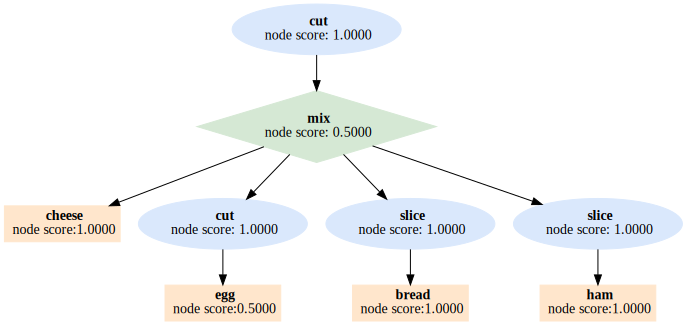

**Recipe Score**: 0.8125

**Ingredients**:
  * bread
  * egg
  * ham
  * cheese


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | cut egg, slice bread, slice ham and mix it with cheese. Then cut it. |


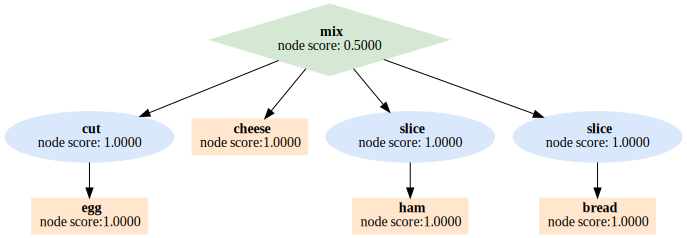

**Recipe Score**: 0.7863636363636365

**Ingredients**:
  * ham
  * egg
  * bread
  * cheese


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | cut egg, slice ham, slice bread and mix it with cheese. |


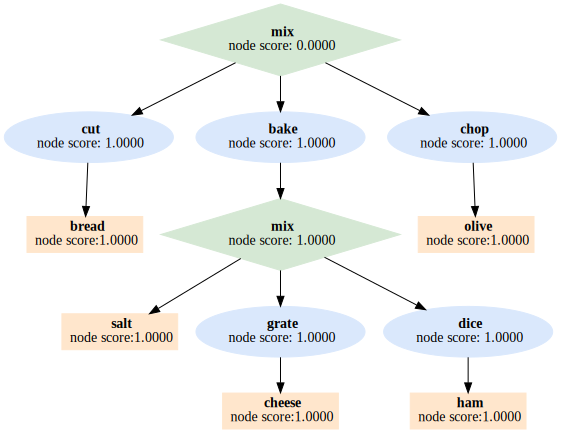

**Recipe Score**: 0.7312500000000001

**Ingredients**:
  * cheese
  * ham
  * olive
  * salt
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | grate cheese, dice ham and mix it with salt. Then bake it. |
| 2 | cut bread, chop olive and mix it together with the results of step 1. |


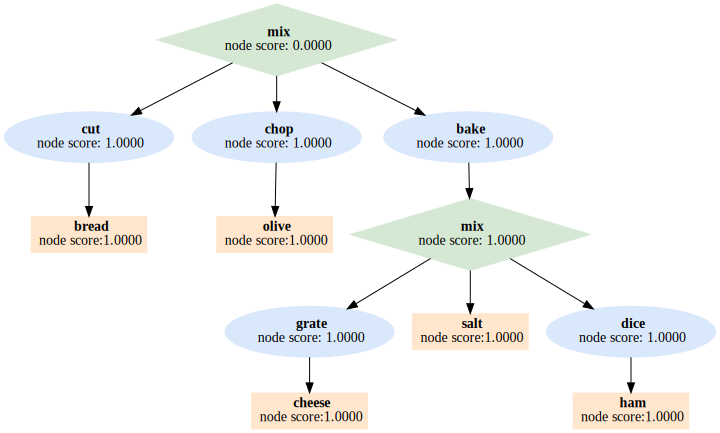

**Recipe Score**: 0.7312500000000001

**Ingredients**:
  * cheese
  * ham
  * olive
  * salt
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | grate cheese, dice ham and mix it with salt. Then bake it. |
| 2 | cut bread, chop olive and mix it together with the results of step 1. |


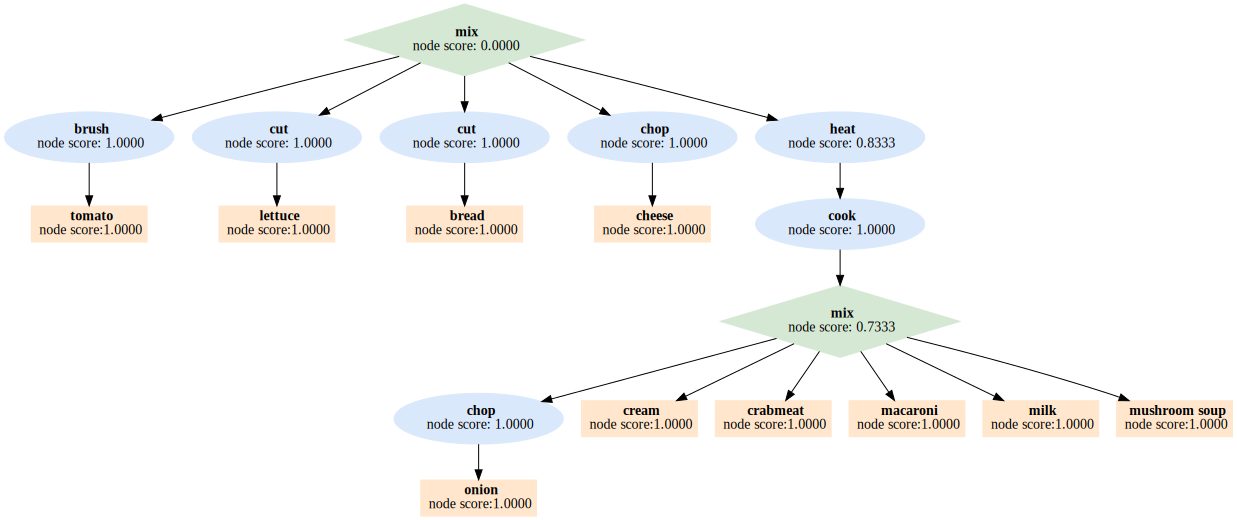

**Recipe Score**: 0.6825000000000001

**Ingredients**:
  * cheese
  * milk
  * mushroom soup
  * tomato
  * cream
  * macaroni
  * lettuce
  * onion
  * bread
  * crabmeat


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | chop onion and mix it with cream, crabmeat, macaroni, milk and mushroom soup. Then cook it. |
| 2 | heat the result of step 1 |
| 3 | brush tomato, cut lettuce, cut bread, chop cheese and mix it together with the results of step 2. |


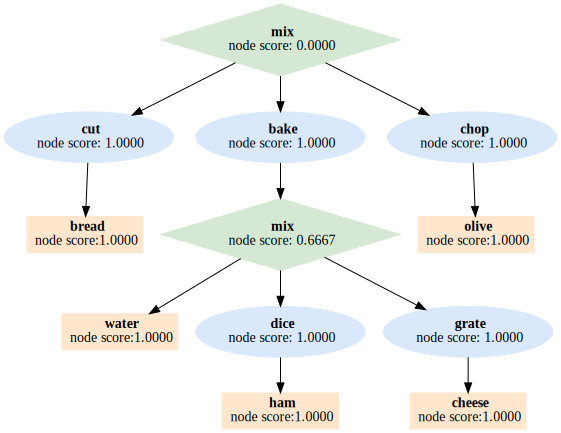

**Recipe Score**: 0.675

**Ingredients**:
  * cheese
  * water
  * ham
  * olive
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | dice ham, grate cheese and mix it with water. Then bake it. |
| 2 | cut bread, chop olive and mix it together with the results of step 1. |


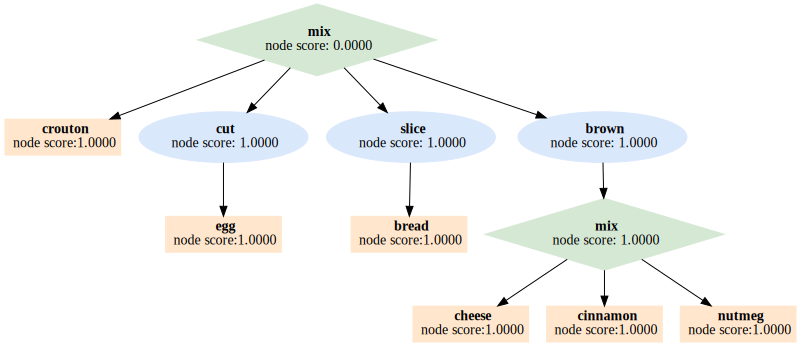

**Recipe Score**: 0.675

**Ingredients**:
  * crouton
  * nutmeg
  * cheese
  * cinnamon
  * bread
  * egg


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | Mix cheese, cinnamon and nutmeg. Then brown it. |
| 2 | cut egg, slice bread and mix it with crouton and mix it together with the results of step 1. |


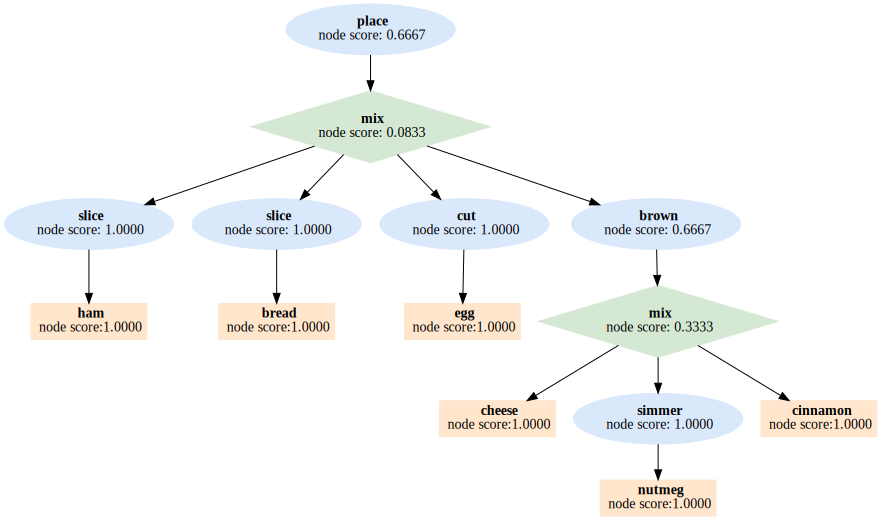

**Recipe Score**: 0.6666666666666666

**Ingredients**:
  * nutmeg
  * cheese
  * ham
  * cinnamon
  * bread
  * egg


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | simmer nutmeg and mix it with cheese and cinnamon. Then brown it. |
| 2 | slice ham, slice bread, cut egg and mix it together with the results of step 1. Then place it. |


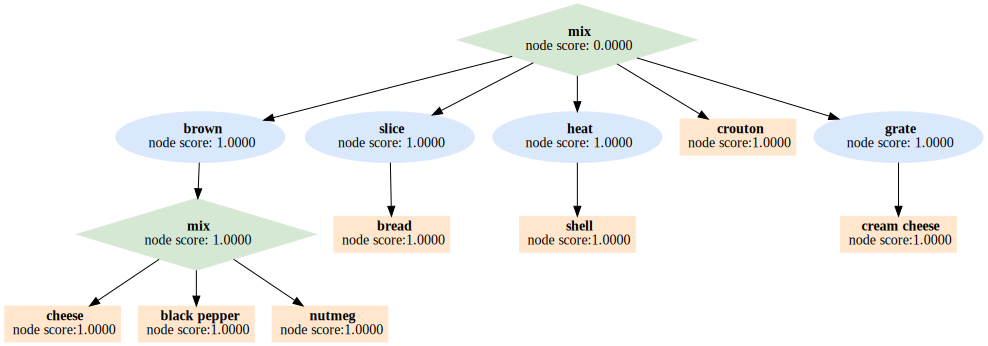

**Recipe Score**: 0.6631578947368421

**Ingredients**:
  * crouton
  * cream cheese
  * nutmeg
  * cheese
  * black pepper
  * bread
  * shell


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | Mix cheese, black pepper and nutmeg. Then brown it. |
| 2 | slice bread, heat shell, grate cream cheese and mix it with crouton and mix it together with the results of step 1. |


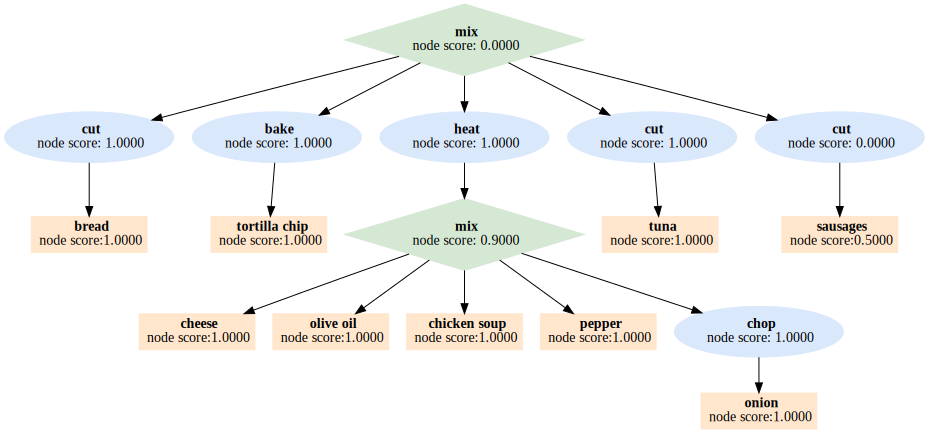

**Recipe Score**: 0.648

**Ingredients**:
  * tortilla chip
  * chicken soup
  * sausages
  * cheese
  * tuna
  * onion
  * olive oil
  * bread
  * pepper


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | chop onion and mix it with cheese, olive oil, chicken soup and pepper. Then heat it. |
| 2 | cut bread, bake tortilla chip, cut tuna, cut sausages and mix it together with the results of step 1. |


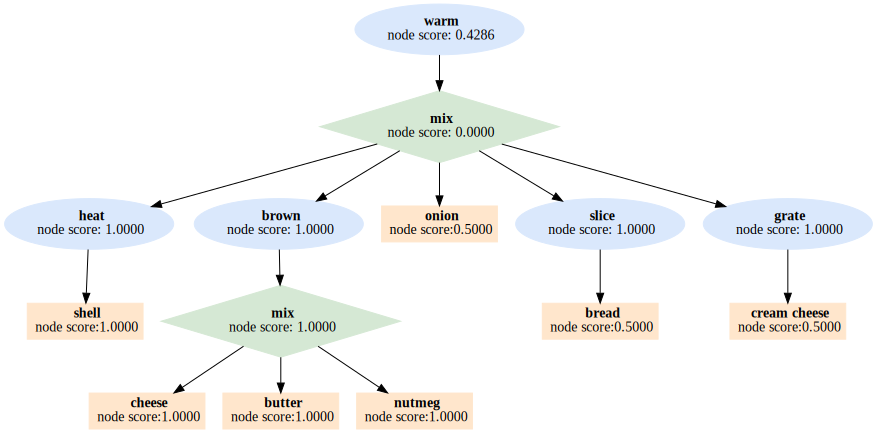

**Recipe Score**: 0.6246428571428572

**Ingredients**:
  * cream cheese
  * nutmeg
  * cheese
  * butter
  * onion
  * bread
  * shell


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | Mix cheese, butter and nutmeg. Then brown it. |
| 2 | heat shell, slice bread, grate cream cheese and mix it with onion and mix it together with the results of step 1. Then warm it. |


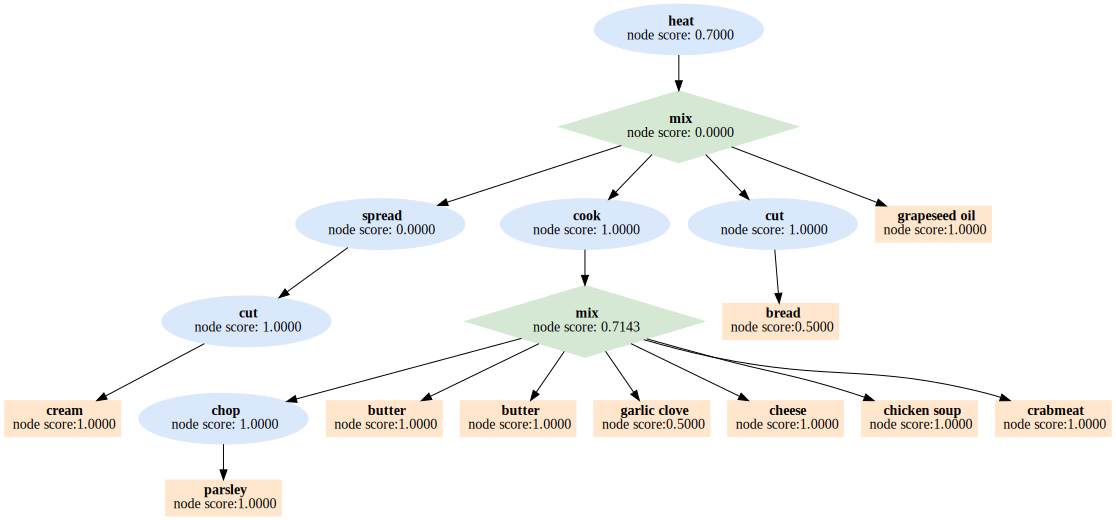

**Recipe Score**: 0.6239999999999999

**Ingredients**:
  * chicken soup
  * cheese
  * butter
  * grapeseed oil
  * cream
  * parsley
  * bread
  * crabmeat
  * garlic clove


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | cut and spread cream |
| 2 | chop parsley and mix it with butter, butter, garlic clove, cheese, chicken soup and crabmeat. Then cook it. |
| 3 | cut bread and mix it with grapeseed oil and mix it together with the results of step 1 and step 2. Then heat it. |


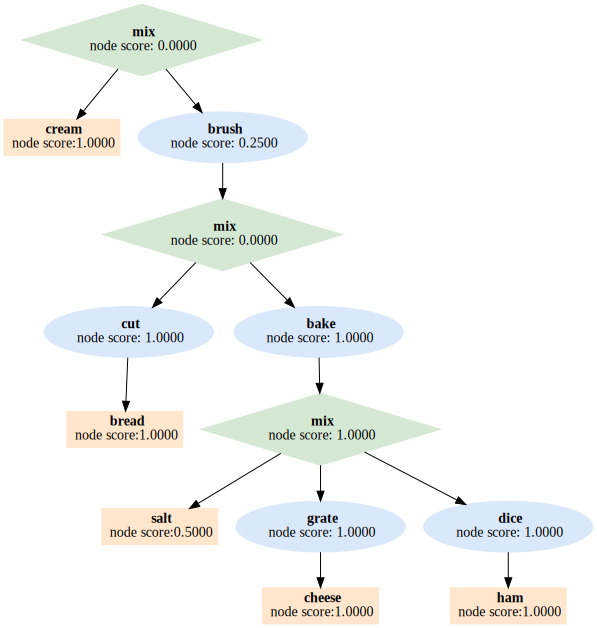

**Recipe Score**: 0.6220588235294118

**Ingredients**:
  * cheese
  * ham
  * cream
  * salt
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | grate cheese, dice ham and mix it with salt. Then bake it. |
| 2 | cut bread and mix it together with the results of step 1. Then brush it. |
| 3 | Mix cream and mix it together with the results of step 2. |


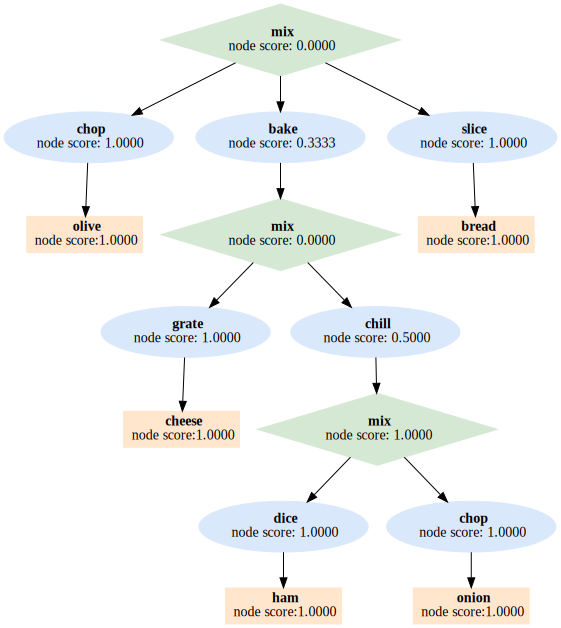

**Recipe Score**: 0.6078947368421053

**Ingredients**:
  * cheese
  * ham
  * olive
  * onion
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | dice ham and chop onion. Then chill it. |
| 2 | grate cheese and mix it together with the results of step 1. Then bake it. |
| 3 | chop olive, slice bread and mix it together with the results of step 2. |


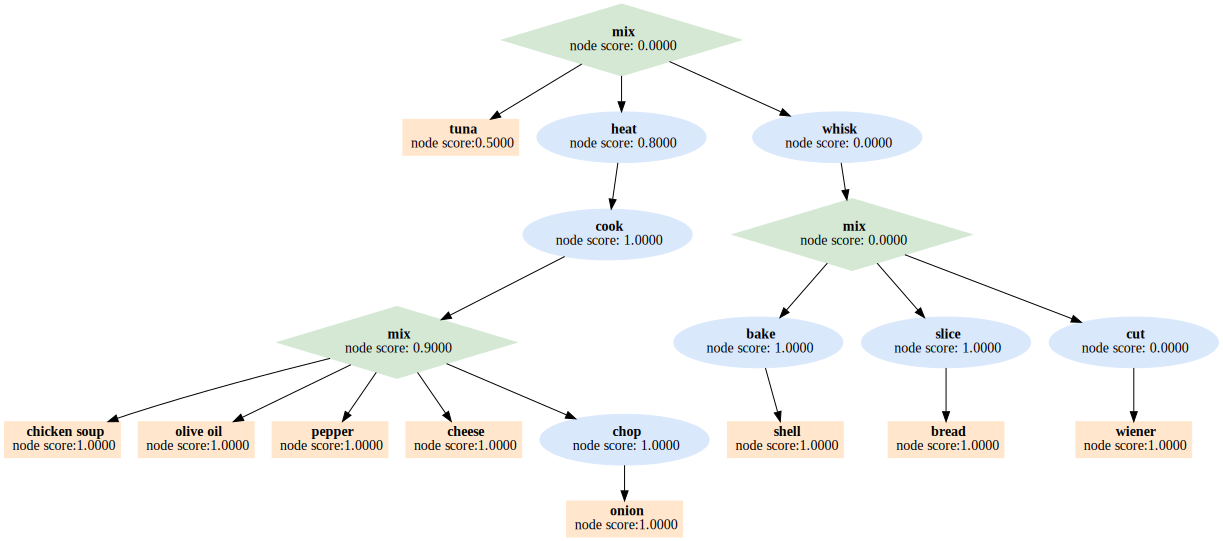

**Recipe Score**: 0.5933333333333334

**Ingredients**:
  * chicken soup
  * cheese
  * wiener
  * tuna
  * onion
  * olive oil
  * bread
  * shell
  * pepper


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | chop onion and mix it with chicken soup, olive oil, pepper and cheese. Then cook it. |
| 2 | heat the result of step 1 |
| 3 | bake shell, slice bread and cut wiener. Then whisk it. |
| 4 | Mix tuna and mix it together with the results of step 2 and step 3. |


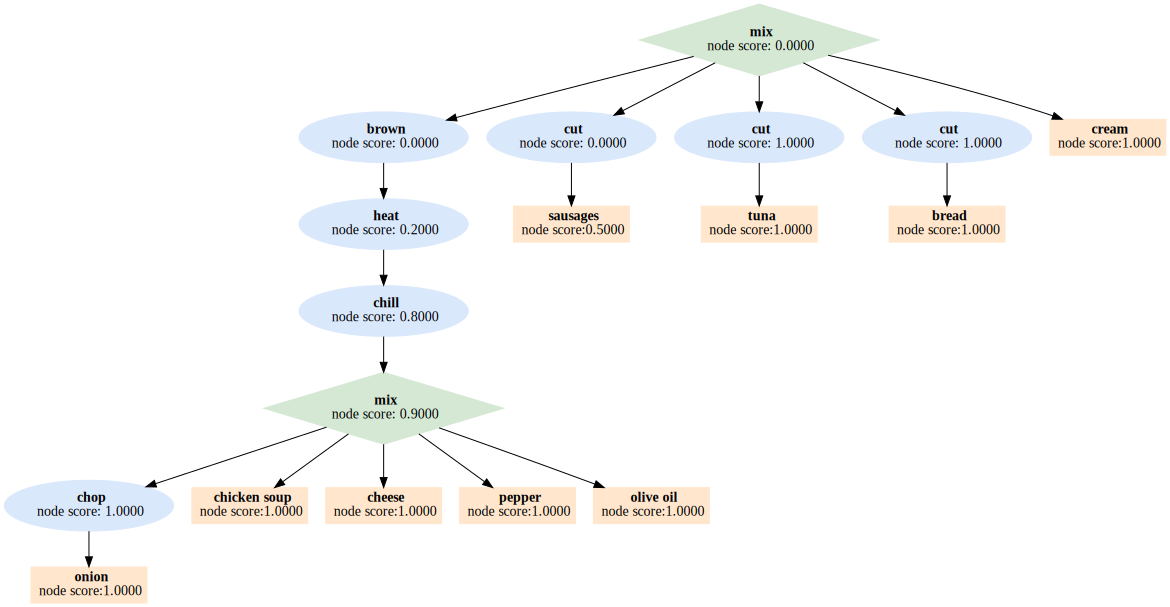

**Recipe Score**: 0.5884615384615385

**Ingredients**:
  * chicken soup
  * sausages
  * cheese
  * tuna
  * cream
  * onion
  * olive oil
  * bread
  * pepper


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | chop onion and mix it with chicken soup, cheese, pepper and olive oil. Then chill it. |
| 2 | heat the result of step 1 |
| 3 | brown the result of step 2 |
| 4 | cut sausages, cut tuna, cut bread and mix it with cream and mix it together with the results of step 3. |


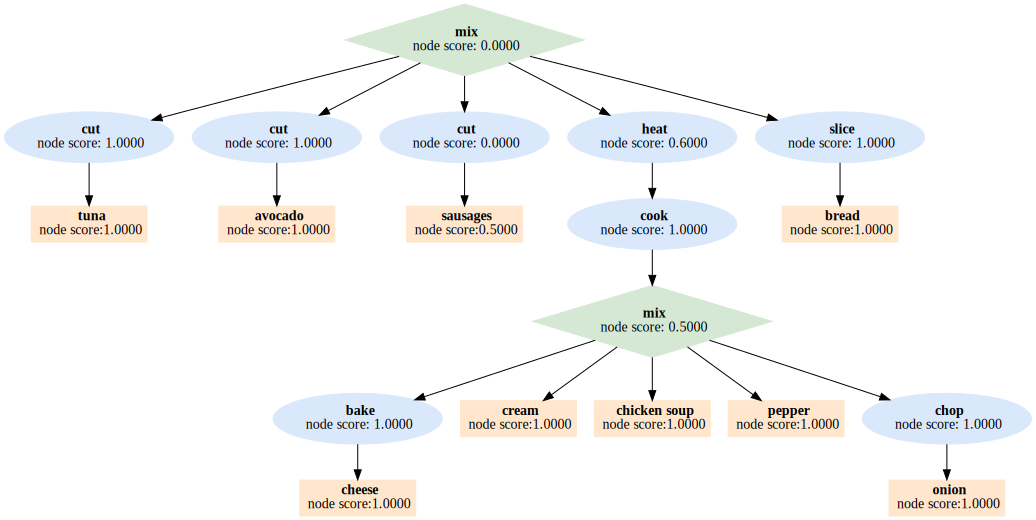

**Recipe Score**: 0.5866666666666668

**Ingredients**:
  * avocado
  * chicken soup
  * cheese
  * tuna
  * cream
  * onion
  * sausages
  * bread
  * pepper


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | bake cheese, chop onion and mix it with cream, chicken soup and pepper. Then cook it. |
| 2 | heat the result of step 1 |
| 3 | cut tuna, cut avocado, cut sausages, slice bread and mix it together with the results of step 2. |


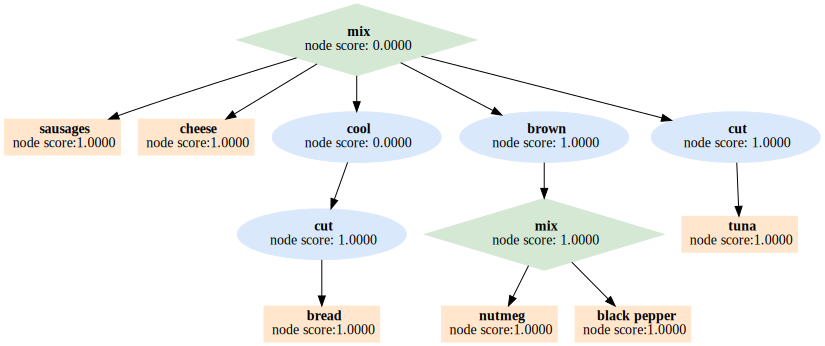

**Recipe Score**: 0.5823529411764706

**Ingredients**:
  * nutmeg
  * cheese
  * black pepper
  * tuna
  * sausages
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | cut and cool bread |
| 2 | Mix nutmeg and black pepper. Then brown it. |
| 3 | cut tuna and mix it with sausages and cheese and mix it together with the results of step 1 and step 2. |


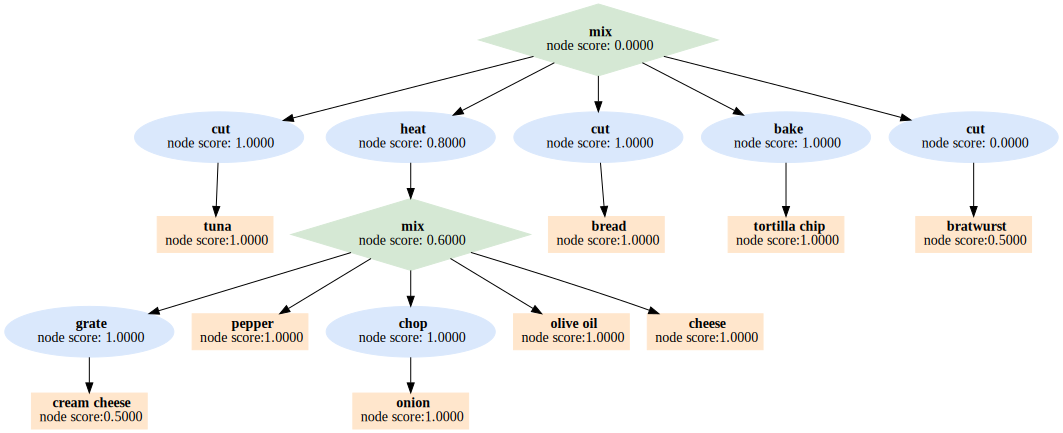

**Recipe Score**: 0.5815384615384616

**Ingredients**:
  * cream cheese
  * tortilla chip
  * cheese
  * tuna
  * bratwurst
  * onion
  * olive oil
  * bread
  * pepper


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | grate cream cheese, chop onion and mix it with pepper, olive oil and cheese. Then heat it. |
| 2 | cut tuna, cut bread, bake tortilla chip, cut bratwurst and mix it together with the results of step 1. |


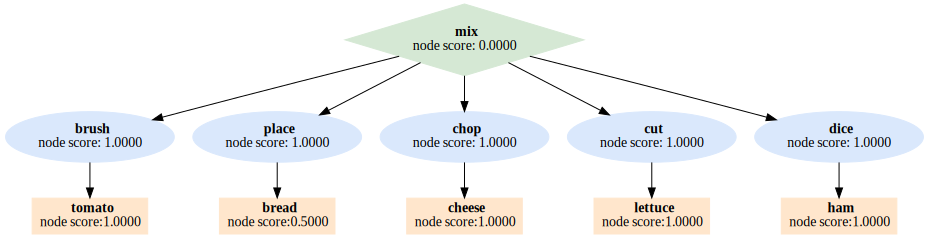

**Recipe Score**: 0.57

**Ingredients**:
  * cheese
  * ham
  * tomato
  * lettuce
  * bread


**Instructions**:

| Step | Instruction |
| ----:|:----------- |
| 1 | brush tomato, place bread, chop cheese, cut lettuce and dice ham. |


In [38]:
p.plot_population(n_best=20)